# Final Project Report
#### Marcus Law, Janesh Tulsan, Winston Tse, Raphael Ysonza

## Introduction

introduction

## Methods

In [32]:
#Loaded libraries necessary for project
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

In [33]:
#Read data set from URL and used janitor library clean_names() to make names cleaner for future use.
url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

player_data <- read_csv(url_players) |>
    clean_names()
player_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age,individual_id,organization_name
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


In [5]:
#Wrangled data: Used one-hot encoding to change experience from a categorical variable to a quantitative variable.
#Also removed outliers: played hours that was greater than 2 standard deviations from the mean and ages that were greater than 90 since those were likely falsified.
players <- player_data |>
    mutate(Pro = ifelse(experience == "Pro", 1, 0),
           Amateur = ifelse(experience == "Amateur", 1, 0),
           Veteran = ifelse(experience == "Veteran", 1, 0),
           Beginner = ifelse(experience == "Beginner", 1, 0),
           Regular = ifelse(experience == "Regular", 1, 0)) |>
    select(-individual_id, -hashed_email, -organization_name) |>
    filter(played_hours < sd(played_hours)*2) |>
    filter(age < 90)

players

experience,subscribe,played_hours,name,gender,age,Pro,Amateur,Veteran,Beginner,Regular
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,TRUE,30.3,Morgan,Male,9,1,0,0,0,0
Veteran,TRUE,3.8,Christian,Male,17,0,0,1,0,0
Veteran,FALSE,0.0,Blake,Male,17,0,0,1,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Pascal,Male,22,0,0,1,0,0
Amateur,FALSE,0.0,Dylan,Prefer not to say,17,0,1,0,0,0
Amateur,FALSE,2.3,Harlow,Male,17,0,1,0,0,0


#### Figure 1

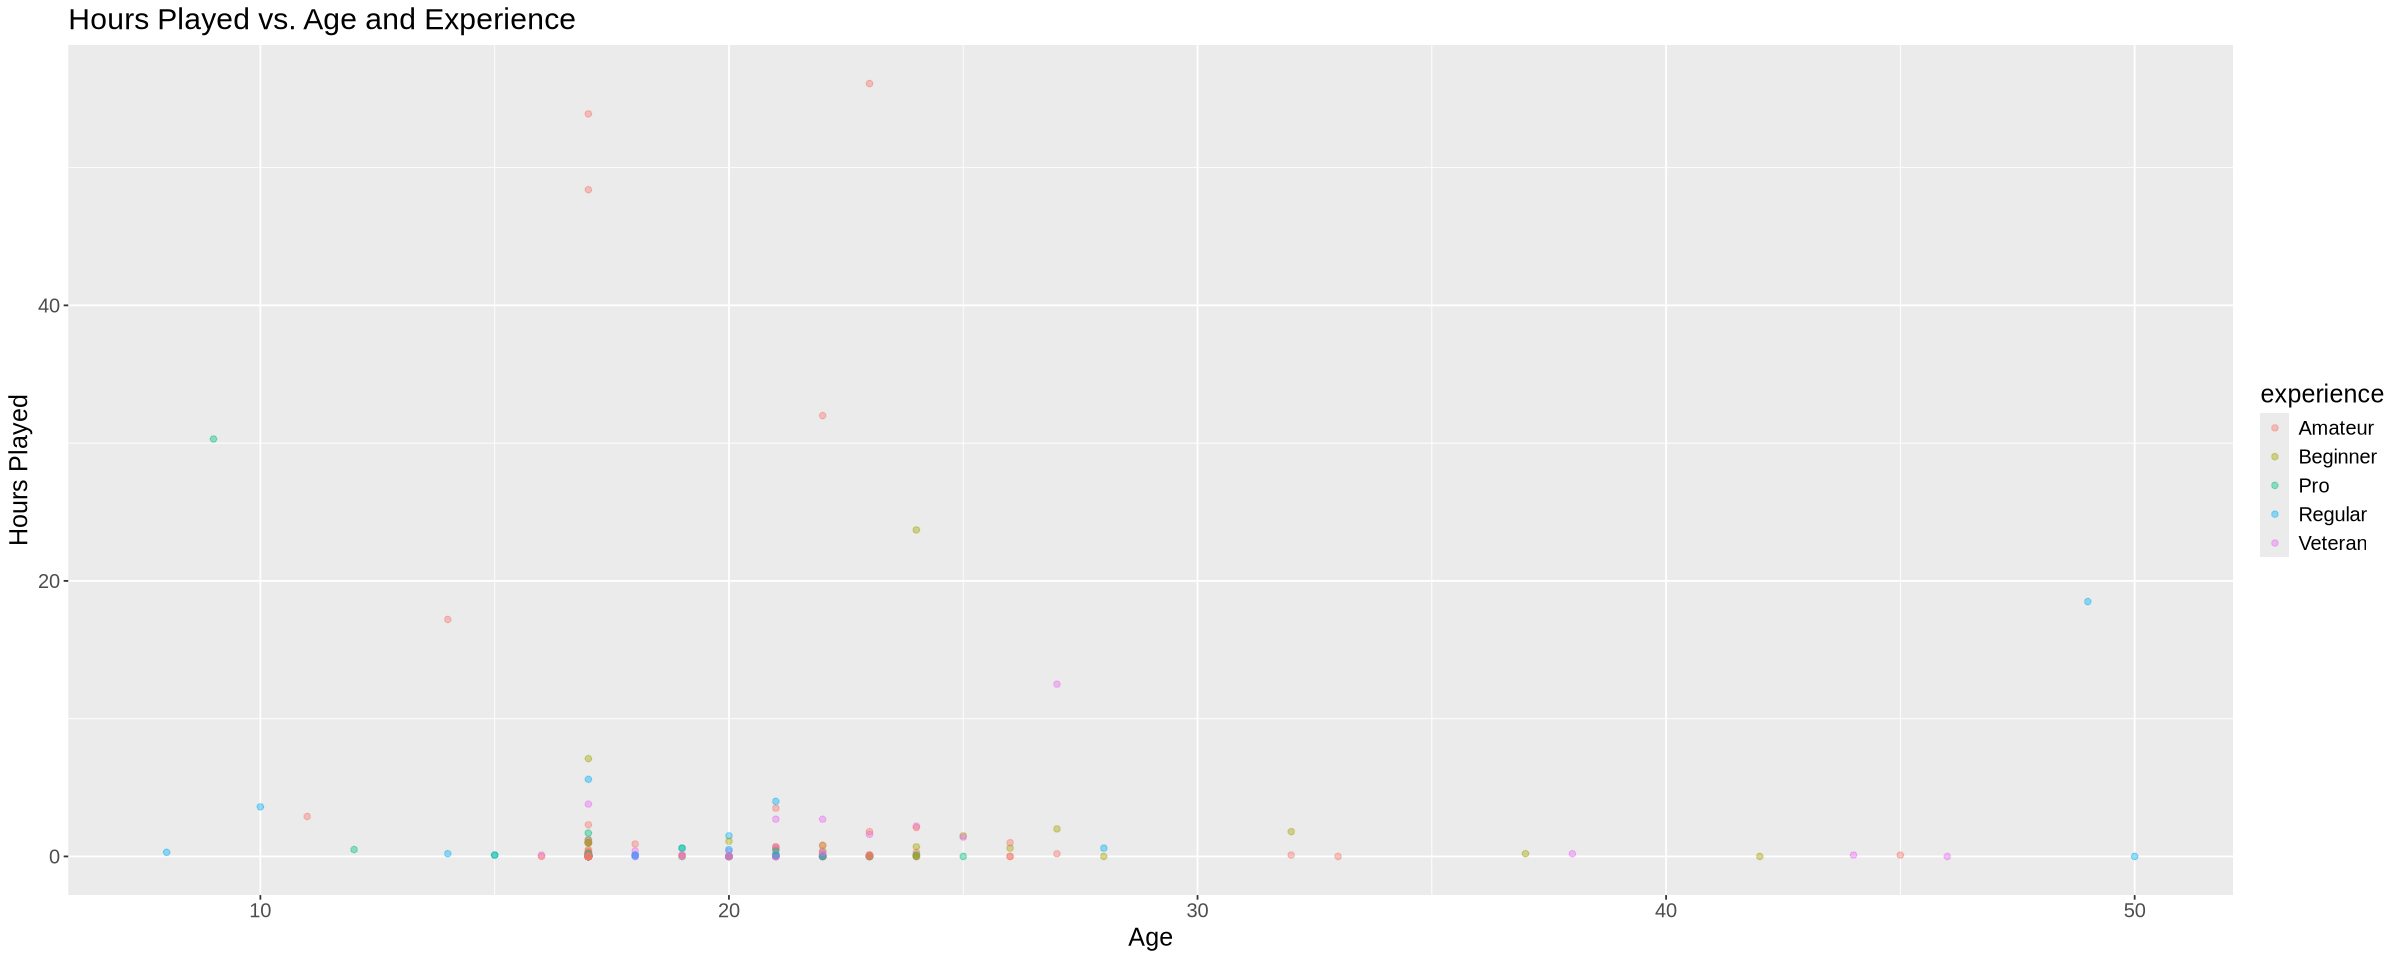

In [22]:
#Visualization of data set with hours played vs. age and colour coded by experience
options(repr.plot.width = 20, repr.plot.height = 8) 

player_EDA <- players |>
ggplot(aes(x = age , y = played_hours, colour = experience)) + 
geom_point(alpha = 0.4) +
labs(x = "Age", 
     y = "Hours Played") +
ggtitle("Hours Played vs. Age and Experience") +
theme(text = element_text(size = 15)) 
player_EDA

In [7]:
#Set seed for reproducibility.
#The player data set was split into 75% training, and 25% testing.
set.seed(1234)
player_split <- initial_split(players, prop = 0.75, strata = played_hours)

player_training <- training(player_split)
player_testing <- testing(player_split)

In [8]:
#Created model for KNN-Regressison with neighbors = tune() so that the ideal k value can be found.
#Created recipe with the desired predictors and scaled all predictors
set.seed(1234)

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

player_recipe <- recipe(played_hours ~ age + Pro + Amateur + Veteran + Beginner + Regular, data = players) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())
player_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [11]:
#Cross validation using vfold_cv to determine the k value for KNN
set.seed(1234)
player_vfold <- vfold_cv(player_training, v = 10, strata = played_hours)

player_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec)
player_workflow

gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

player_results <- player_workflow |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics()
player_results

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,7.13070680,10,1.76555881,Preprocessor1_Model01
1,rsq,standard,0.01600764,10,0.00445332,Preprocessor1_Model01
2,rmse,standard,9.32548072,10,1.45475880,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,rsq,standard,0.06341947,10,0.01867990,Preprocessor1_Model19
20,rmse,standard,7.29674260,10,1.52899738,Preprocessor1_Model20
20,rsq,standard,0.05523249,10,0.02077538,Preprocessor1_Model20


In [24]:
set.seed(1234)
#Filtered for the k value with the lowest RMSE.
player_min <- player_results |>
   filter(.metric == "rmse") |>
   slice_min(std_err, n = 1)
player_min

k_min <- player_min |>
         pull(neighbors)

#Setting up recipe and workflow using the determined k value so predictions can be made on the testing data set.
player_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

player_best_fit <- workflow() |>
         add_recipe(player_recipe) |>
         add_model(player_best_spec) |>
         fit(data = player_training)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,9.325481,10,1.454759,Preprocessor1_Model02


In [13]:
#RMSPE for the model on the testing data
set.seed(1234)
player_summary <- player_best_fit |>
          predict(player_testing) |>
          bind_cols(player_testing) |>
          metrics(truth = played_hours, estimate = .pred) 
player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.8274065674
rsq,standard,0.0002744597
mae,standard,1.5062500000


#### Figure 2

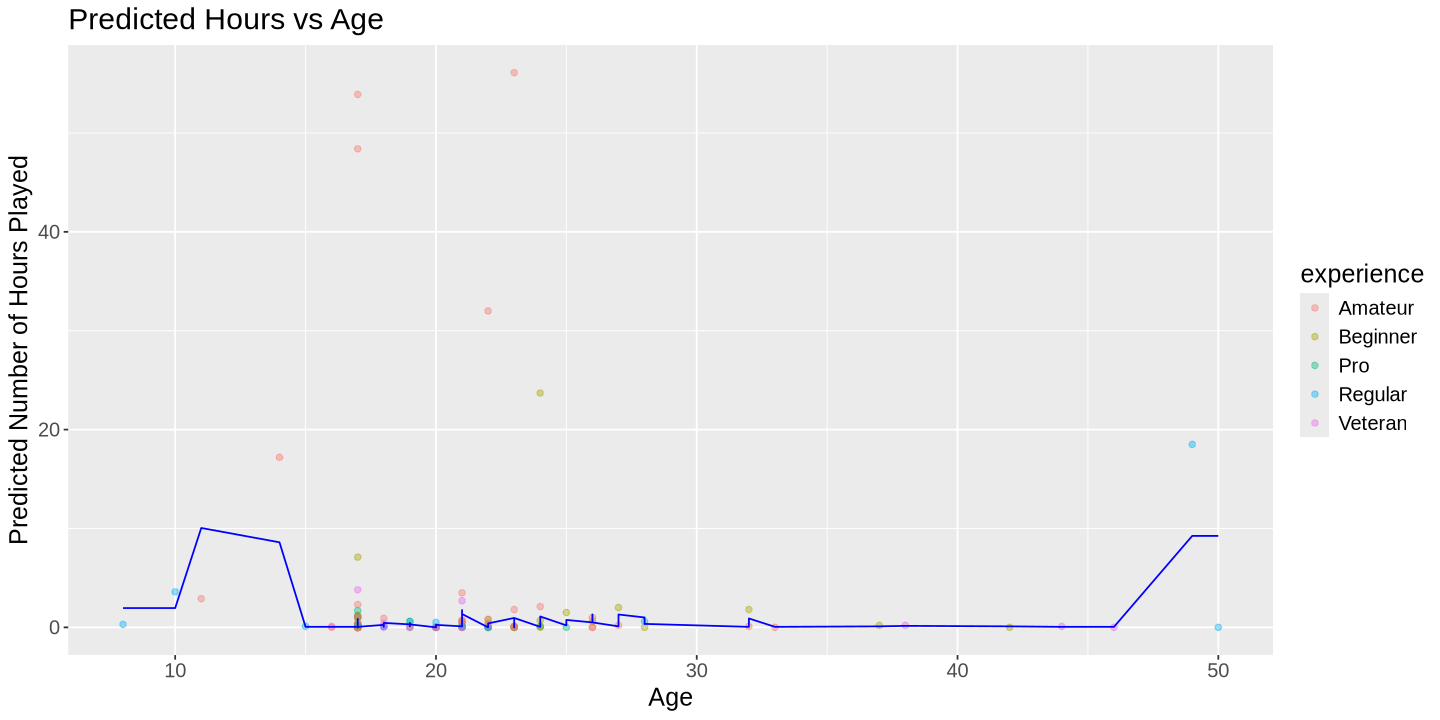

In [26]:
#Graph for visualizing predicted number of hours played shown by the line on the original scatter plot with the true values.

options(repr.plot.width = 12, repr.plot.height = 6)

player_preds <- player_best_fit |>
  predict(player_training) |>
  bind_cols(player_training)

player_plot <- player_preds |>
ggplot(aes(x = age , y = played_hours, colour = experience)) + 
geom_point(alpha = 0.4) +
geom_line(data = player_preds,
          mapping = aes(x = age, y = .pred), 
          color = "blue",) +
labs(x = "Age", 
     y = "Predicted Number of Hours Played") +
ggtitle("Predicted Hours vs Age ") +
theme(text = element_text(size = 15)) 

player_plot

#### Figure 3

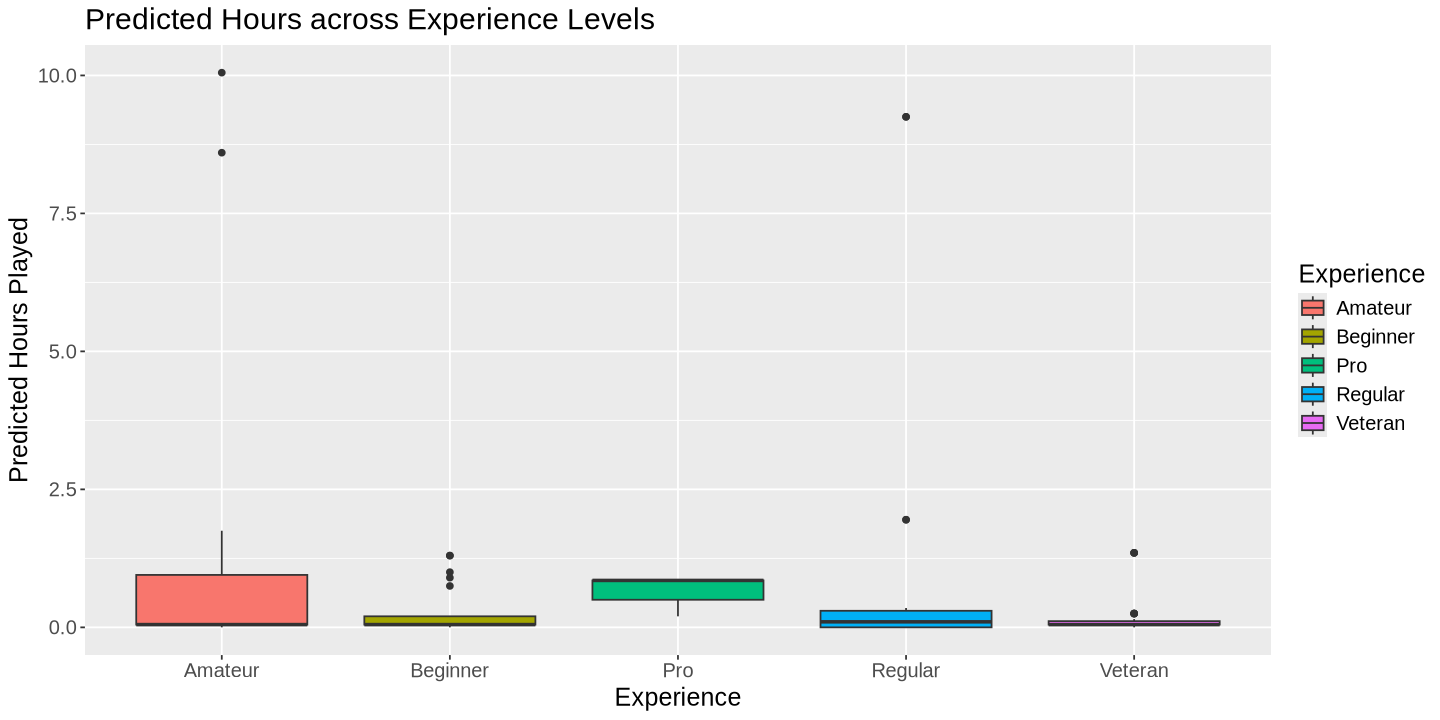

In [16]:
#Boxplot for visualizing the predicted hours played across the experience levels.

player_boxplot <- player_preds |>
ggplot(aes(x = experience , y = .pred, fill = experience)) + 
geom_boxplot() +
labs(x = "Experience", 
     y = "Predicted Hours Played",
     fill = "Experience") +
ggtitle("Predicted Hours across Experience Levels") +
theme(text = element_text(size = 15)) 
player_boxplot

#### Figure 4

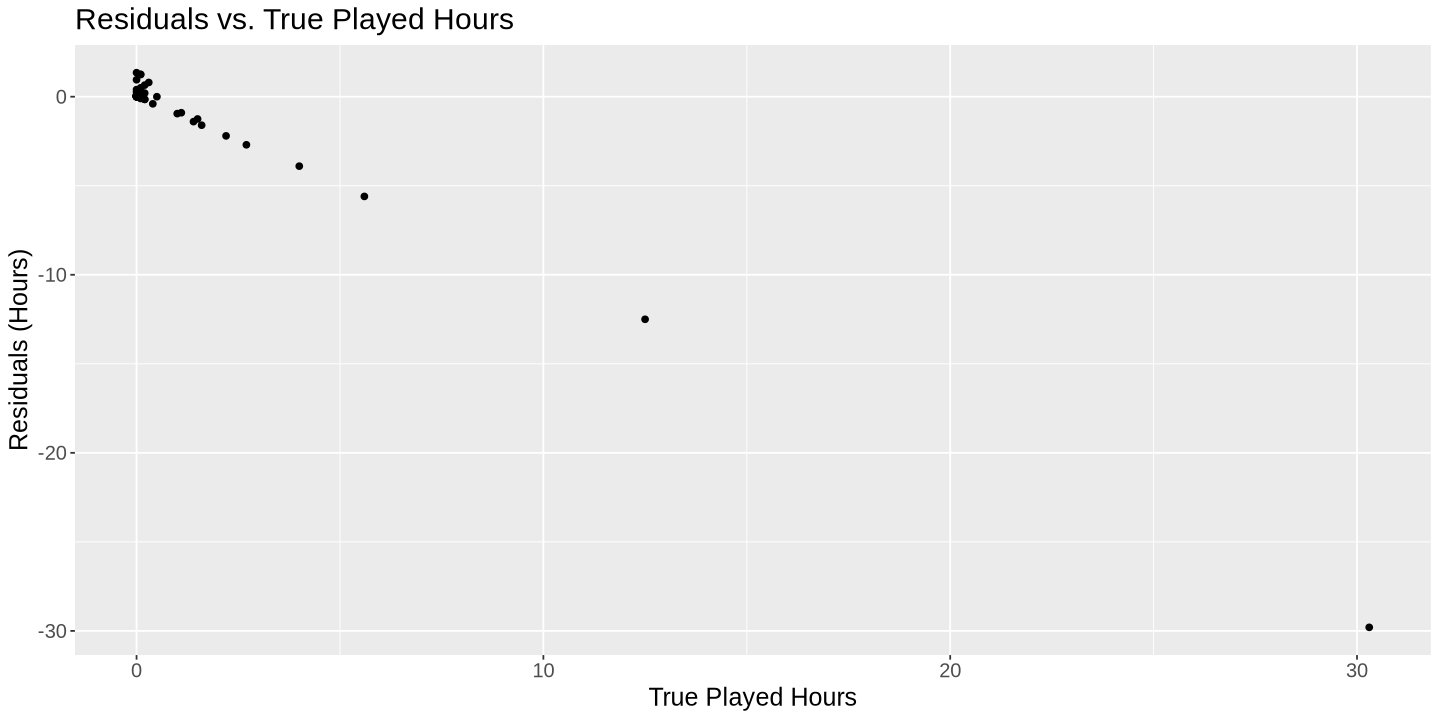

In [30]:
#Graph showing the error (residuals) between the true value and the predicted value.

player_Tpreds <- player_best_fit |>
    predict(player_testing) |>
    bind_cols(player_testing) |>
    mutate(residuals = .pred - played_hours)   

error_plot <- player_Tpreds |>
    ggplot(alpha = 0.4) +
    geom_point(aes(x = played_hours, y = residuals)) + 
    xlab("True Played Hours") + 
    ylab("Residuals (Hours)") +
    ggtitle("Residuals vs. True Played Hours") +
    theme(text = element_text(size = 15)) 
error_plot

## Results

results

## Discussion

Discussion